In [1]:
#Importing all Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim

import nltk
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import seaborn as sns
from plotly import graph_objs as go
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('wordnet2022')

[nltk_data] Downloading package wordnet to /Users/manas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /Users/manas/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


True

In [2]:
youtube_comments = pd.read_csv('comments.csv')

In [3]:
youtube_comments.head()

Unnamed: 0     Video ID                                            Comment  \
0           0  wAZZ-UWGVHI  Let's not forget that Apple Pay in 2014 requir...   
1           1  wAZZ-UWGVHI  Here in NZ 50% of retailers don’t even have co...   
2           2  wAZZ-UWGVHI  I will forever acknowledge this channel with t...   
3           3  wAZZ-UWGVHI  Whenever I go to a place that doesn’t take App...   
4           4  wAZZ-UWGVHI  Apple Pay is so convenient, secure, and easy t...   

   Likes  Sentiment  
0   95.0        1.0  
1   19.0        0.0  
2  161.0        2.0  
3    8.0        0.0  
4   34.0        2.0

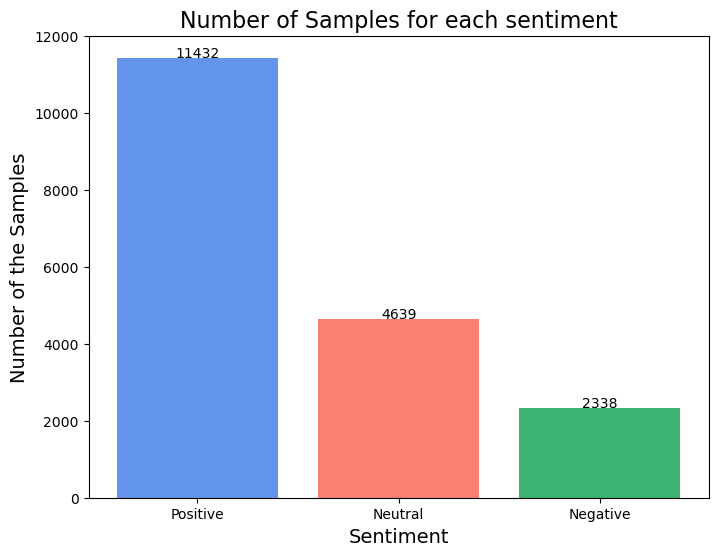

In [4]:
colors = ['cornflowerblue', 'salmon', 'mediumseagreen']
counting = youtube_comments.Sentiment.value_counts() #counting sentiment values
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Neutral', 'Negative'],counting, color=colors)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of the Samples', fontsize=14)
plt.title("Number of Samples for each sentiment", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for i, count in enumerate(counting):
    plt.text(i, count + 10, str(count), ha='center', fontsize=10)

plt.show()

In [5]:
First_corpus = pd.DataFrame(columns=['Text','Label'])
First_corpus['Text'],First_corpus['Label'] = youtube_comments['Comment'],youtube_comments['Sentiment']

In [6]:
First_corpus.head(40)


Text  Label
0   Let's not forget that Apple Pay in 2014 requir...    1.0
1   Here in NZ 50% of retailers don’t even have co...    0.0
2   I will forever acknowledge this channel with t...    2.0
3   Whenever I go to a place that doesn’t take App...    0.0
4   Apple Pay is so convenient, secure, and easy t...    2.0
5   We’ve been hounding my bank to adopt Apple pay...    1.0
6   We only got Apple Pay in South Africa in 2020/...    2.0
7   For now, I need both Apple Pay and the physica...    1.0
8   In the United States, we have an abundance of ...    2.0
9   In Cambodia, we have a universal QR code syste...    1.0
10  Wow, you really went to town on the PSU test r...    2.0
11  The lab is the most exciting thing in IT I've ...    2.0
12  Linus, I'm an engineer and love the LMG conten...    2.0
13  There used to be a time where Linus was the sm...    2.0
14  Holy crap. I was looking at Chroma systems bac...    0.0
15  I love the direction this channel is going. Mo...    2.0
16  I am more excited for the LTT Lab than I have ...    2.0
17  I adore the working relationship Linus has wit...    2.0
18  LMGs growth is honestly something to truly asp...    2.0
19  I love all the people LTT has added for labs. ...    2.0
20  Linus!!! Just turn the key lights  180 and bou...    2.0
21  Dan continues to be my new favorite, he has su...    2.0
22  Dan managing to set up his soldering station o...    2.0
23  Linus: *Gets on his employee's cases for all t...    2.0
24  Linus: "This is not a table."\nAlso Linus: Let...    1.0
25  Dan the man. Saving the day. Riley needs to gi...    2.0
26  Dan continues to be a favourite for me. He's l...    2.0
27  Dan is a treasure. Your channel has long lacke...    2.0
28  Blows my mind how quickly Dan became the "rock...    2.0
29  Hey Linus, a good trick for streaming lights: ...    2.0
30  Unstoppable experiments with liquid nitrogen 🎉...    2.0
31  "one of the best things about dude is that he ...    2.0
32  Liquid nitrogen ഇതുവരെ തീർന്നില്ലേ മച്ചാനെ.......    1.0
33         Liquid nitrogen never ends🤗\nM4tech poli😎😎    2.0
34  29minutes 48k views 9.3k likes 👍🏻 that is the ...    2.0
35  😻😅 കേരളത്തിൽ ആദ്യമായി പെട്രോളിനെ എയ്സ് ആക്കിയ ...    1.0
36  Epozhum safety is first priority.... goggles o...    2.0
37  Congratulations m4tech for achieving 8 million...    2.0
38  തന്നെ തളർത്താൻ നോക്കിയവർ പോലും അവന്റെ ഉയർച്ചയി...    1.0
39          എത്ര എടുത്താലും തീരാത്ത liquid nitrogen 😂    1.0

In [7]:
# Dropping duplicate rows
First_corpus.drop_duplicates(inplace=True)

# Checking if 'Text' column has all unique values
print(First_corpus.Text.is_unique)

# Printing the number of samples after removing duplicates
print(f'Number of Samples after removing duplicates: {len(First_corpus)}')

# Retain all sentiment classes and proceed with multi-class classification
# No need to drop any rows or modify the labels for binary classification


True
Number of Samples after removing duplicates: 17995


In [8]:
# Assign the DataFrame to a new variable for clarity (optional)
df = First_corpus

# Display the count of each label in the 'Label' column
print("Label Counts:\n", df.Label.value_counts())

# Display the total number of samples
print(f'The total number of samples: {len(df)}')

# Preview the first 10 rows of the DataFrame
df.head(10)



Label Counts:
 Label
2.0    11141
1.0     4533
0.0     2321
Name: count, dtype: int64
The total number of samples: 17995


Text  Label
0  Let's not forget that Apple Pay in 2014 requir...    1.0
1  Here in NZ 50% of retailers don’t even have co...    0.0
2  I will forever acknowledge this channel with t...    2.0
3  Whenever I go to a place that doesn’t take App...    0.0
4  Apple Pay is so convenient, secure, and easy t...    2.0
5  We’ve been hounding my bank to adopt Apple pay...    1.0
6  We only got Apple Pay in South Africa in 2020/...    2.0
7  For now, I need both Apple Pay and the physica...    1.0
8  In the United States, we have an abundance of ...    2.0
9  In Cambodia, we have a universal QR code syste...    1.0

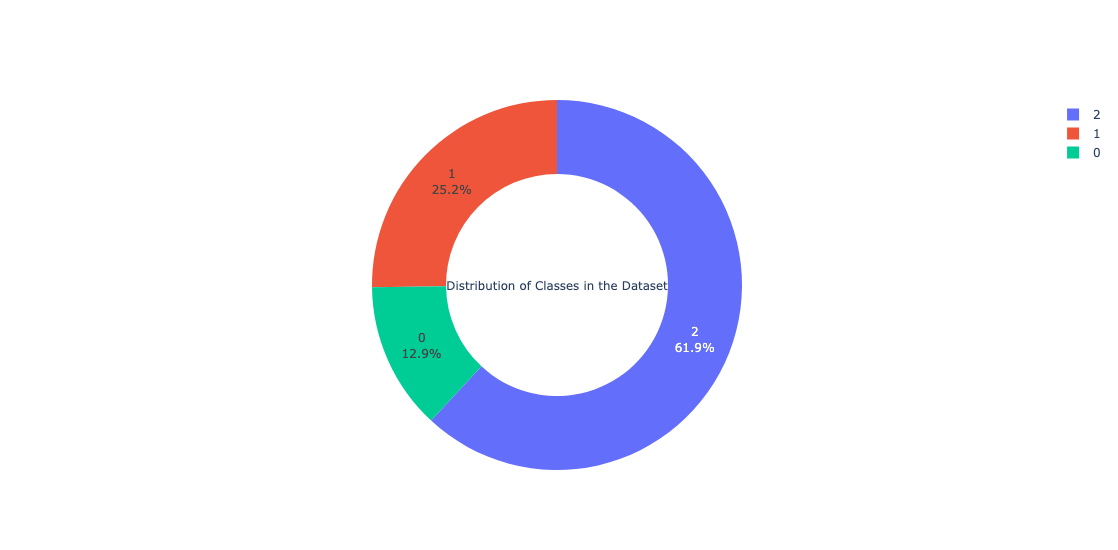

In [9]:
import plotly.graph_objects as go

# Get the label distribution using value_counts
labels = df['Label'].value_counts().index
values = df['Label'].value_counts().values

# Create the pie chart (donut chart by setting the hole)
fig = go.Figure(data=[go.Pie(labels=labels, 
                              values=values, 
                              hole=0.6,  # This creates the "donut" effect
                              textinfo='percent+label',  # Show percentages and labels
                              title='Distribution of Classes in the Dataset')])

# Update the layout for a clean look
fig.update_layout(title_font_size=20, title_x=0.5, width=750, height=550)

# Display the pie chart
fig.show()



In [10]:
#Defining a function that remove unnecessary characters
def cleaning(text):
    text = re.sub(r'#\w+','', text)                 # Removing Hashtags
    text = re.sub(r'http\S+','', text)              # Removing Links & URLs
    text = re.sub(r'@\w+','', text)                 # Removing Mentions
    text = re.sub('[()!?.\';:<>`$%’,]', '', text)   # Removing Punctuations with different forms
    text = re.sub(r'[^a-zA-Z]',' ', text)           # Removing digits
    text = re.sub(r'([a-zA-Z])\1{2,}','\1', text)   # Reduce duplicated character (> 3) to only one
    return text

#Defining the most used list of Abbreviations to be expanded to its original form
abbreviations = {'fyi': 'for your information',
                 'lol': 'laugh out loud',
                 'loza': 'laughs out loud',
                 'lmao': 'laughing',
                 'rofl': 'rolling on the floor laughing',
                 'vbg': 'very big grin',
                 'xoxo': 'hugs and kisses',
                 'xo': 'hugs and kisses',
                 'brb': 'be right back',
                 'tyt': 'take your time',
                 'thx': 'thanks',
                 'abt': 'about',
                 'bf': 'best friend',
                 'diy': 'do it yourself',
                 'faq': 'frequently asked questions',
                 'fb': 'facebook',
                 'idk': 'i don\'t know',
                 'asap': 'as soon as possible',
                 'syl': 'see you later',
                 'nvm': 'never mind',
                 'frfr':'for real for real',
                 'istg':'i swear to god',
    }


In [11]:
#Data cleaning fucntion to call the above cleaning function, converting the characters to lower case 
#and expanding the most used abbreviations

def DataCleaning(corpus):
    corpus['Text'] = corpus['Text'].apply(cleaning)     # Calling cleaning function (1-7)
    corpus['Text'] = corpus['Text'].str.lower()         # Normalize all characters to lowercase
    for abbreviation, full_form in abbreviations.items(): # Expanding the Abbreviations
        corpus['Text'] = corpus['Text'].str.replace(abbreviation, full_form)
    return corpus

In [12]:
import re

# Function to clean text data and handle non-string values
def cleaning(text):
    if not isinstance(text, str):
        return ''  # Return an empty string for non-string values (e.g., NaN or float)

    text = re.sub(r'#\w+', '', text)                 # Removing Hashtags
    text = re.sub(r'http\S+', '', text)              # Removing Links & URLs
    text = re.sub(r'@\w+', '', text)                 # Removing Mentions
    text = re.sub('[()!?.\';:<>`$%’,]', '', text)    # Removing Punctuations with different forms
    text = re.sub(r'[^a-zA-Z]', ' ', text)           # Removing digits and non-alphabetical characters
    text = re.sub(r'([a-zA-Z])\1{2,}', r'\1', text)  # Reduce duplicated characters (> 3) to only one
    
    # Converting text to lower case
    text = text.lower()

    # Expanding abbreviations
    for abbreviation, expansion in abbreviations.items():
        text = re.sub(r'\b' + abbreviation + r'\b', expansion, text)  # Replace abbreviations

    return text


In [13]:
# Data cleaning function that applies the cleaning function to the corpus
def DataCleaning(corpus):
    # Apply the cleaning function to the 'Text' column
    corpus['Text'] = corpus['Text'].apply(cleaning)
    
    return corpus


In [14]:
df = DataCleaning(df)

In [15]:
print(f"The total number of samples: {len(df)}")
df.drop_duplicates(inplace=True)                # Dropping duplicated texts if exist after Cleaning
df.dropna(inplace=True)                         # Dropping Null values if exist after Cleaning
print(f"The total number of samples after removal: {len(df)}")

The total number of samples: 17995
The total number of samples after removal: 17779


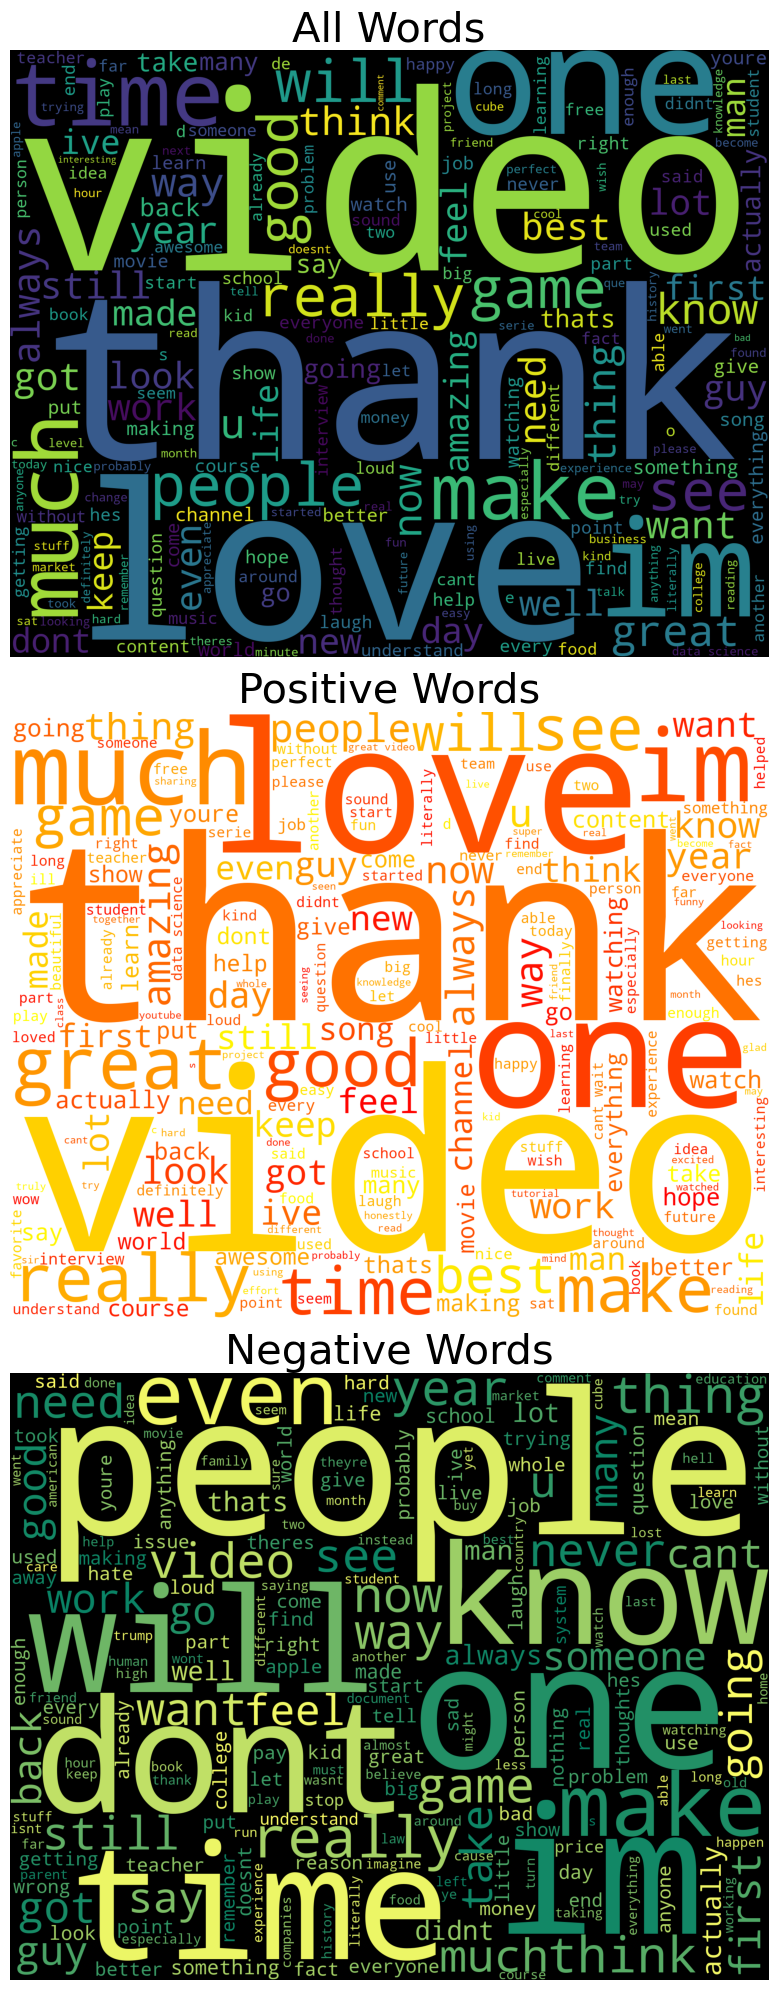

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Adjust the figure and axis settings
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

# Generate word clouds for all words
all_words = WordCloud(
    background_color='black',
    width=2000,
    height=1600,
    colormap='viridis'
).generate(' '.join(df['Text']))

# Generate word cloud for positive class (assuming label 2.0 is for positive)
positive_words = WordCloud(
    background_color='white',
    width=2000,
    height=1600,
    colormap='autumn'
).generate(" ".join(df[df['Label'] == 2.0]['Text']))

# Generate word cloud for neutral class (assuming label 1.0 is for neutral)
neutral_words = WordCloud(
    background_color='white',
    width=2000,
    height=1600,
    colormap='Blues'
).generate(" ".join(df[df['Label'] == 1.0]['Text']))

# Generate word cloud for negative class (assuming label 0.0 is for negative)
negative_words = WordCloud(
    background_color='black',
    width=2000,
    height=1600,
    colormap='summer'
).generate(" ".join(df[df['Label'] == 0.0]['Text']))

# Plot all words
ax[0].imshow(all_words)
ax[0].set_title('All Words', fontsize=30)
ax[0].axis('off')

# Plot positive words
ax[1].imshow(positive_words)
ax[1].set_title('Positive Words', fontsize=30)
ax[1].axis('off')

# Plot negative words
ax[2].imshow(negative_words)
ax[2].set_title('Negative Words', fontsize=30)
ax[2].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')  # Download the stopwords corpus

# Function to remove stopwords
def remove_stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))  # Load stopwords
    return ' '.join([word for word in text.split() if word.lower() not in stopwords])

# Apply stopword removal
df['Text'] = df['Text'].apply(remove_stopwords)

# Tokenizing the text
df['Tokenized'] = df['Text'].apply(lambda x: word_tokenize(x) if isinstance(x, str) else [])

# Defining all Required Parameters for WordNet Lemmatizer (POS Tags Reducing - POS Tagging)
lemmatizer = WordNetLemmatizer()

# Defining POS tagging function to reduce Nouns to N, Adjectives to J, etc.
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Defining the lemmatization function
def lemmatization(tokens):
    new_sen = []
    pos_tagged = pos_tag(tokens)  # POS tagging
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]  # POS Tagging & Reducing
    for word, tag in wordnet_tagged:
        if tag is None:
            new_sen.append(word)  # Keep original word if tag is None
        else:
            new_sen.append(lemmatizer.lemmatize(word, tag))  # Lemmatizing

    return new_sen

# Apply lemmatization to the Tokenized column
df['Tokenized'] = df['Tokenized'].apply(lambda x: lemmatization(x) if isinstance(x, list) else [])

# Regrouping the words into sentences and removing duplicates or Null Values
df['Text'] = df['Tokenized'].apply(lambda x: " ".join(x) if x else '')

# Print total number of samples
print(f"The total number of samples: {len(df)}")


[nltk_data] Downloading package punkt to /Users/manas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/manas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The total number of samples: 17779


The shape of the dataset: (17779, 3554)

Some of the vocabulary:  [('let', 1804), ('forget', 1245), ('apple', 180), ('pay', 2274), ('require', 2626), ('brand', 383), ('new', 2113), ('iphone', 1659), ('order', 2206), ('use', 3344)]




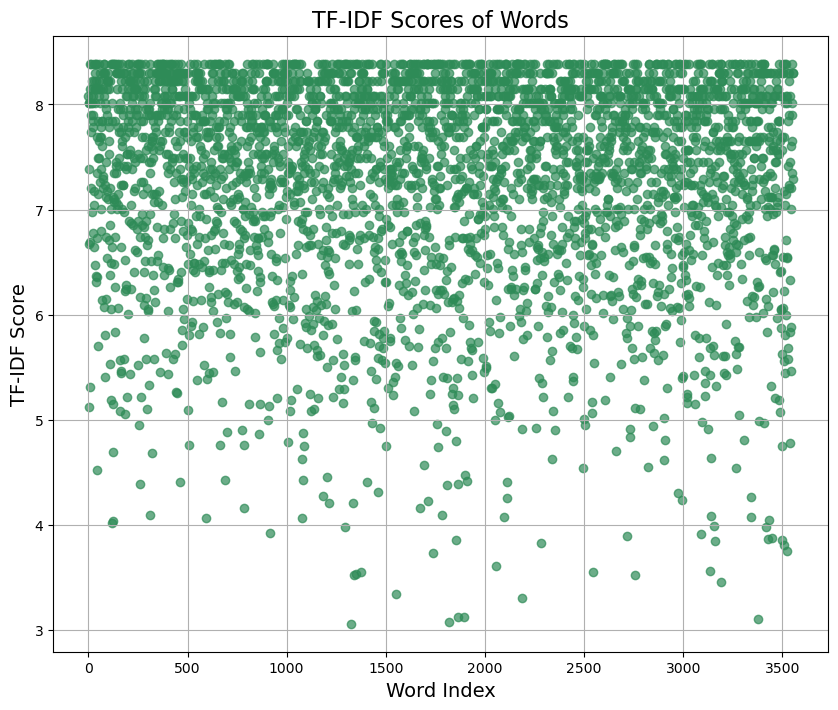

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming df is already defined and contains 'Text' and 'Label' columns

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    strip_accents='ascii',   # Remove non-ASCII characters
    analyzer='word',         # Tokenization at word level
    smooth_idf=True,         # Smooth IDF calculation
    norm=None,               # No normalization
    min_df=10                # Ignore terms that appear in less than 10 documents
)

# Fit and transform the text data
X = vectorizer.fit_transform(df['Text'])
y = df['Label'].astype('Int64')  # Convert labels to Int64 type for compatibility

# Displaying the shape of the TF-IDF matrix and a sample of the vocabulary
print("The shape of the dataset:", X.shape)
print("\nSome of the vocabulary: ", list(vectorizer.vocabulary_.items())[:10])
print("\n")

# Retrieve and plot the IDF scores
idf_scores = vectorizer.idf_

# Plotting the TF-IDF scores of words
plt.figure(figsize=(10, 8))
plt.scatter(range(len(idf_scores)), idf_scores, alpha=0.7, marker='o', color='seagreen')
plt.title('TF-IDF Scores of Words', fontsize=16)
plt.xlabel('Word Index', fontsize=14)
plt.ylabel('TF-IDF Score', fontsize=14)
plt.grid(True)  # Add a grid for better readability
plt.show()


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined and contain the TF-IDF features and labels respectively

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30,       # 30% of the data will be used for testing
    shuffle=True,         # Shuffle the data before splitting
    random_state=41       # For reproducibility
)

# Defining a DataFrame to hold the evaluation metrics for model comparison
result = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision Score', 'Recall Score', 'F1-Score'])

# Optional: Display the sizes of the training and testing sets for reference
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 12445
Testing set size: 5334


In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# List to hold the results
t_result = []

# Hyperparameter tuning for n_estimators
for i in range(1, 11):
    # Initialize Random Forest Classifier with current n_estimators
    RF = RandomForestClassifier(n_estimators=i, criterion='entropy', n_jobs=-1)
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(RF, X_train, y_train, cv=5)  # 5-fold cross-validation
    RF.fit(X_train, y_train)  # Fit the model on the entire training set
    
    # Predict on the training set
    prediction = RF.predict(X_train)

    # Calculate evaluation metrics
    t_result.append((
        i, 
        scores.mean(),  # Use the mean accuracy from cross-validation
        precision_score(y_train, prediction, average='weighted'), 
        recall_score(y_train, prediction, average='weighted'), 
        f1_score(y_train, prediction, average='weighted')
    ))

# Create a DataFrame to store the results
results_df = pd.DataFrame(t_result, columns=['n_estimators', 'Mean Accuracy', 'Precision Score', 'Recall Score', 'F1 Score'])

# Display the results
print(results_df)


   n_estimators  Mean Accuracy  Precision Score  Recall Score  F1 Score
0             1       0.625472         0.861330      0.860587  0.860777
1             2       0.589474         0.888695      0.869024  0.873334
2             3       0.666292         0.932042      0.932182  0.931963
3             4       0.671756         0.948540      0.948011  0.948191
4             5       0.685818         0.961711      0.961832  0.961729
5             6       0.688309         0.972325      0.972278  0.972291
6             7       0.694014         0.974007      0.974046  0.973971
7             8       0.698433         0.978675      0.978626  0.978634
8             9       0.703656         0.982024      0.982001  0.981993
9            10       0.702692         0.985890      0.985858  0.985868


<Figure size 1000x800 with 0 Axes>

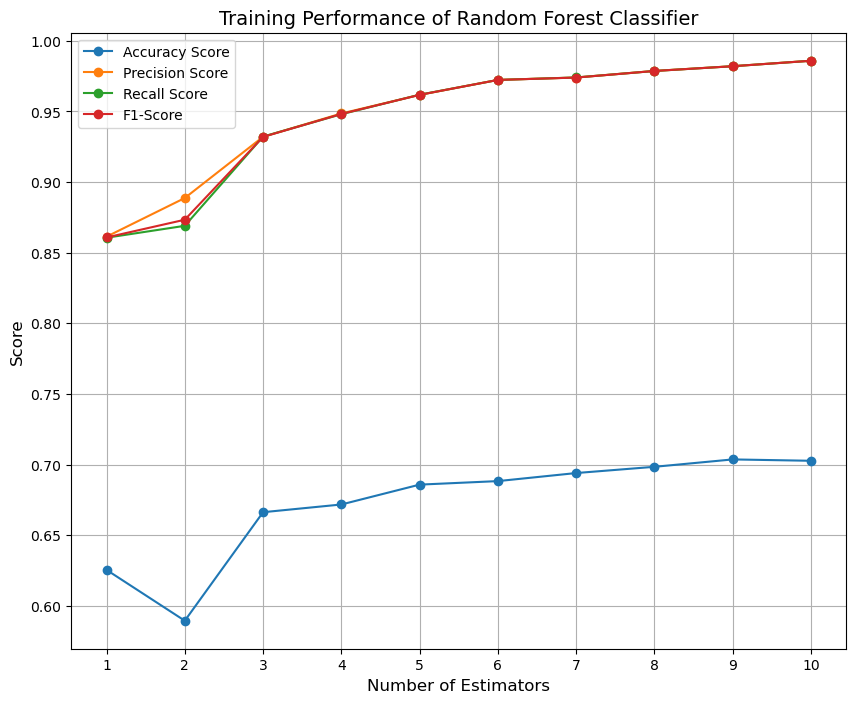

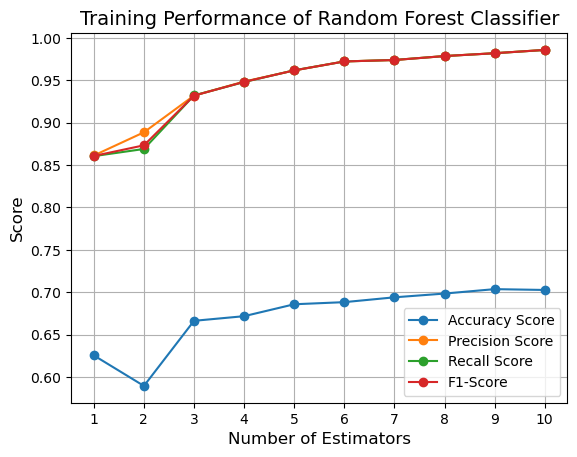

In [21]:
import matplotlib.pyplot as plt

# Assuming you have your t_result from the previous code block
# Create a DataFrame for plotting
result_df = pd.DataFrame(t_result, columns=['num. of estimator', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

# Plotting the Training Performance
plt.figure(figsize=(10, 8))
import matplotlib.pyplot as plt

# Assuming you have your t_result from the previous code block
# Create a DataFrame for plotting
result_df = pd.DataFrame(t_result, columns=['num. of estimator', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

# Plotting the Training Performance
plt.figure(figsize=(10, 8))

plt.plot(result_df['num. of estimator'], result_df['Accuracy'], marker='o', label='Accuracy Score')
plt.plot(result_df['num. of estimator'], result_df['Precision'], marker='o', label='Precision Score')
plt.plot(result_df['num. of estimator'], result_df['Recall'], marker='o', label='Recall Score')
plt.plot(result_df['num. of estimator'], result_df['F1-score'], marker='o', label='F1-Score')

plt.xlabel("Number of Estimators", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Training Performance of Random Forest Classifier", fontsize=14)
plt.xticks(result_df['num. of estimator'])  # Set x-ticks to match number of estimators
plt.legend()
plt.grid()
plt.show()

plt.plot(result_df['num. of estimator'], result_df['Accuracy'], marker='o', label='Accuracy Score')
plt.plot(result_df['num. of estimator'], result_df['Precision'], marker='o', label='Precision Score')
plt.plot(result_df['num. of estimator'], result_df['Recall'], marker='o', label='Recall Score')
plt.plot(result_df['num. of estimator'], result_df['F1-score'], marker='o', label='F1-Score')

plt.xlabel("Number of Estimators", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Training Performance of Random Forest Classifier", fontsize=14)
plt.xticks(result_df['num. of estimator'])  # Set x-ticks to match number of estimators
plt.legend()
plt.grid()
plt.show()


In [22]:
# Training the classifier on 10 estimators for best performance
RF = RandomForestClassifier(n_estimators= 10, criterion='entropy', n_jobs=-1)
RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1)

In [23]:
prediction = RF.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.46      0.27      0.34       704
         1.0       0.57      0.47      0.51      1351
         2.0       0.75      0.88      0.81      3279

    accuracy                           0.69      5334
   macro avg       0.59      0.54      0.56      5334
weighted avg       0.67      0.69      0.67      5334



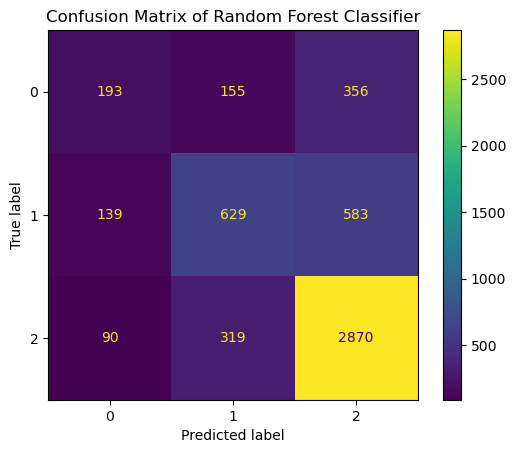

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have your predictions ready
prediction = RF.predict(X_test)  # Make sure this is done after fitting the model

# Compute the confusion matrix
cm_matrix = confusion_matrix(y_test, prediction)

# Check unique classes to update display labels accordingly
unique_labels = set(y_test)
display_labels = ['Negative', 'Positive'] if len(unique_labels) == 2 else list(unique_labels)

# Plotting the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=display_labels)
cm_display.plot()
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Storing the evaluation Result of the Random Forest Classifier
model_result = ['Random Forest Classifier',
                accuracy_score(y_test, prediction), 
                precision_score(y_test, prediction, average='weighted'), 
                recall_score(y_test, prediction, average='weighted'),
                f1_score(y_test, prediction, average='weighted')]

result.loc[len(result)] = model_result


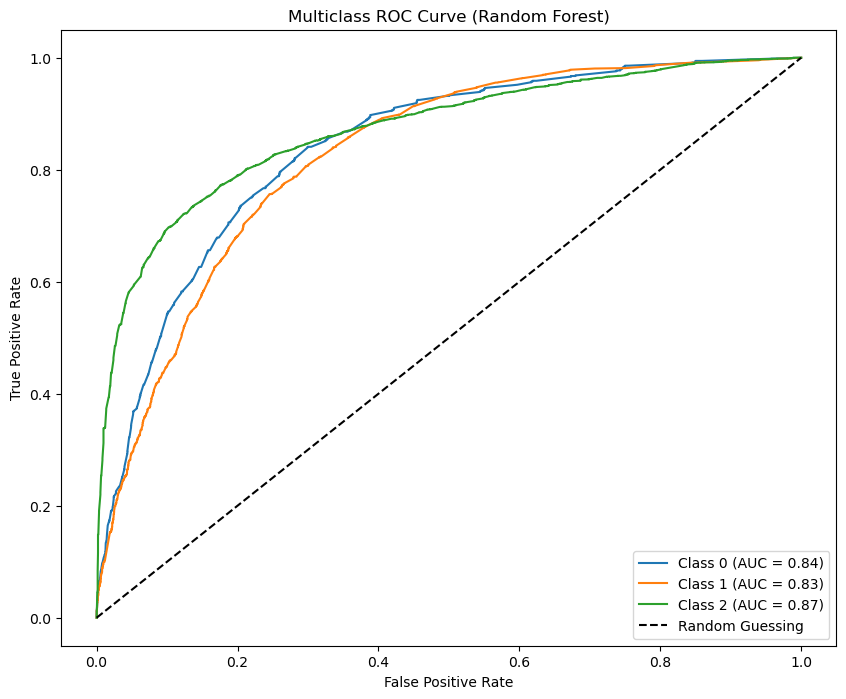

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train, X_test, and y_test are already defined
# Train the Random Forest model
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_proba = RF.predict_proba(X_test)

# Binarize the true labels for multiclass ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC and AUC for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.show()


   C value  Accuracy  Precision    Recall  F1-score
0      0.1  0.877139   0.874959  0.877139  0.874575
1      0.2  0.877541   0.875383  0.877541  0.874976
2      0.3  0.877782   0.875651  0.877782  0.875238
3      0.4  0.877863   0.875724  0.877863  0.875325
4      0.5  0.877863   0.875724  0.877863  0.875325
5      0.6  0.877863   0.875724  0.877863  0.875325
6      0.7  0.877863   0.875724  0.877863  0.875325
7      0.8  0.877863   0.875724  0.877863  0.875325
8      0.9  0.877863   0.875724  0.877863  0.875325
9      1.0  0.877863   0.875724  0.877863  0.875325


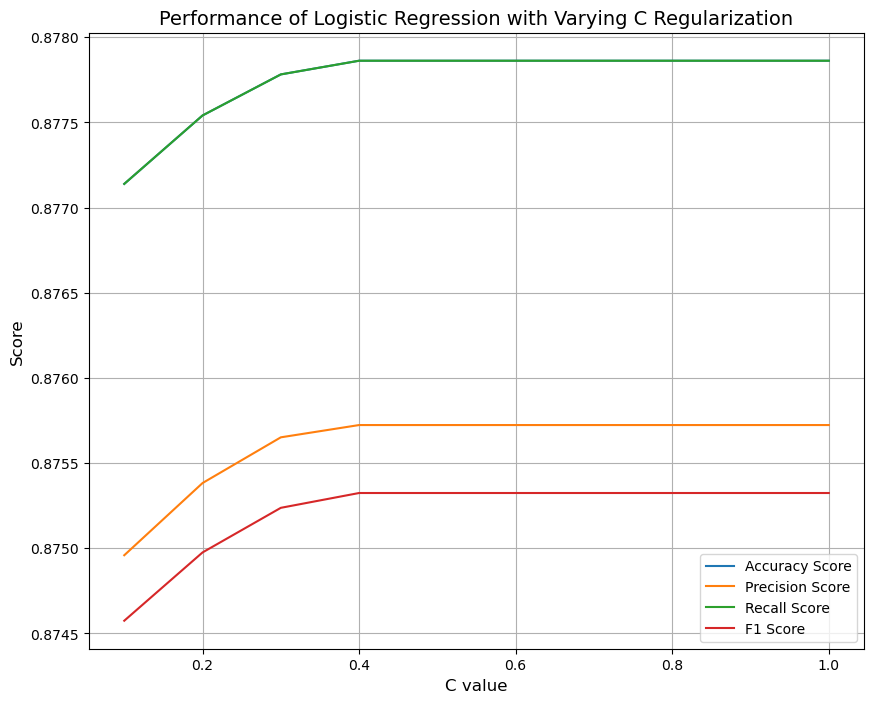

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# Assuming X_train, y_train have already been defined and are available
# Initialize an empty list to store results
t_result = []

# Set initial value and increment for C
itr = 0.1

# Perform hyperparameter tuning for C regularization
while itr <= 1.0:
    LGR = LogisticRegression(penalty='l2', C=itr, fit_intercept=True,
                             random_state=41, solver='sag', max_iter=1000)
    LGR.fit(X_train, y_train)
    
    # Predict on the training set
    prediction = LGR.predict(X_train)
    
    # Append the results (C, accuracy, precision, recall, F1-score)
    t_result.append((
        itr,
        accuracy_score(y_train, prediction),
        precision_score(y_train, prediction, average='weighted'),  # Using weighted average for multiclass
        recall_score(y_train, prediction, average='weighted'),
        f1_score(y_train, prediction, average='weighted')
    ))
    
    # Increment C
    itr += 0.1

# Convert results to DataFrame for easy visualization
result_df = pd.DataFrame(t_result, columns=['C value', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

# Print the results
print(result_df)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(result_df['C value'], result_df['Accuracy'], label='Accuracy Score')
plt.plot(result_df['C value'], result_df['Precision'], label='Precision Score')
plt.plot(result_df['C value'], result_df['Recall'], label='Recall Score')
plt.plot(result_df['C value'], result_df['F1-score'], label='F1 Score')
plt.xlabel("C value", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Performance of Logistic Regression with Varying C Regularization", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


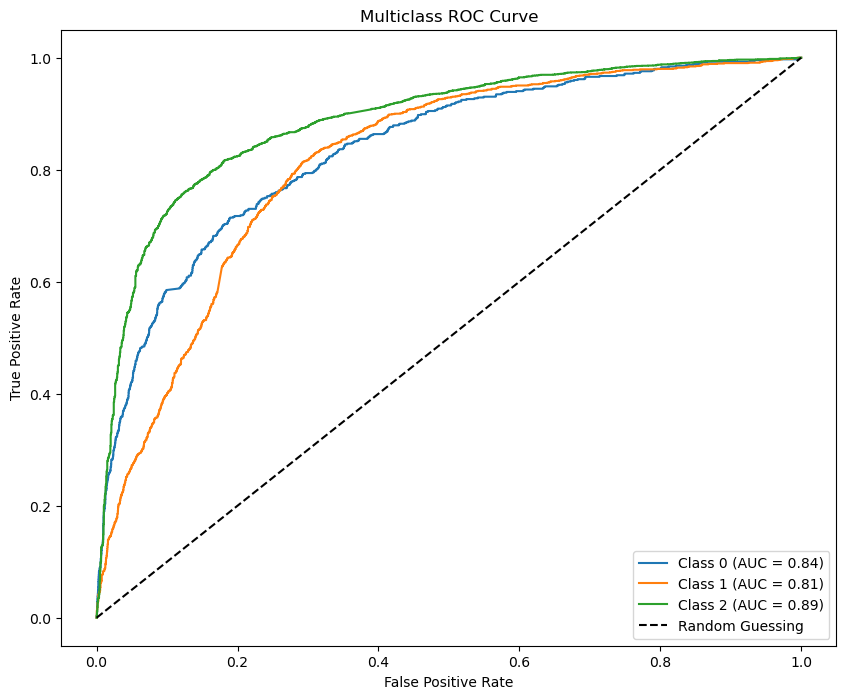

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming your labels are in y_test and your model is LGR
# Predict probabilities for each class
y_pred_proba = LGR.predict_proba(X_test)

# Binarize the true labels for multiclass ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC and AUC for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()



In [29]:
# Training the Logistic Regression for C = 0.9 for best performance
LGR = LogisticRegression(penalty='l2', dual=False, C=0.9, fit_intercept=True
                        , random_state = 41, solver = 'sag', max_iter=1000)
LGR.fit(X_train, y_train)

LogisticRegression(C=0.9, max_iter=1000, random_state=41, solver='sag')

In [30]:
prediction = LGR.predict(X_test)
print(classification_report(y_test,prediction)) 

              precision    recall  f1-score   support

         0.0       0.51      0.49      0.50       704
         1.0       0.56      0.48      0.52      1351
         2.0       0.82      0.87      0.84      3279

    accuracy                           0.72      5334
   macro avg       0.63      0.61      0.62      5334
weighted avg       0.71      0.72      0.72      5334



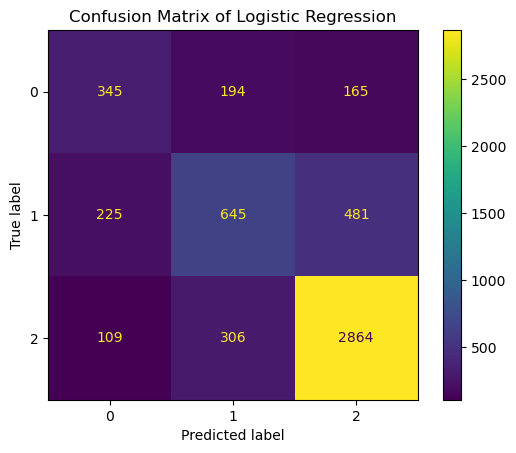

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
prediction = LGR.predict(X_test)

# Displaying the Confusion Matrix of Logistic Regression
cm_matrix = confusion_matrix(y_test, prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_matrix)

# Update display labels based on unique classes
cm_display.display_labels = np.unique(y_test)  # Set display labels to unique classes
cm_display.plot()
plt.title("Confusion Matrix of Logistic Regression")
plt.show()


In [32]:
# Storing the evaluation results of Logistic Regression
model_result = [
    'Logistic Regression',
    accuracy_score(y_test, prediction),
    precision_score(y_test, prediction, average='weighted'),  # Use weighted average for multiclass
    recall_score(y_test, prediction, average='weighted'),      # Use weighted average for multiclass
    f1_score(y_test, prediction, average='weighted')           # Use weighted average for multiclass
]

result.loc[len(result)] = model_result


In [33]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

MultinomialNB()

In [34]:
# Training Classification Report
print("\t\tThe Training Classification Report")
train_prediction = NB.predict(X_train)
train_report = classification_report(y_train, train_prediction, output_dict=True)
print(classification_report(y_train, train_prediction))  # Display the Training Classification Report
print('\n')

# Evaluation Classification Report
print("\t\tThe Evaluation Classification Report")
test_prediction = NB.predict(X_test)
test_report = classification_report(y_test, test_prediction, output_dict=True)
print(classification_report(y_test, test_prediction))    # Display the Testing Classification Report


		The Training Classification Report
              precision    recall  f1-score   support

         0.0       0.53      0.84      0.65      1616
         1.0       0.73      0.46      0.56      3070
         2.0       0.85      0.87      0.86      7759

    accuracy                           0.76     12445
   macro avg       0.70      0.72      0.69     12445
weighted avg       0.78      0.76      0.76     12445



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.41      0.70      0.52       704
         1.0       0.60      0.37      0.46      1351
         2.0       0.81      0.82      0.82      3279

    accuracy                           0.69      5334
   macro avg       0.61      0.63      0.60      5334
weighted avg       0.71      0.69      0.69      5334



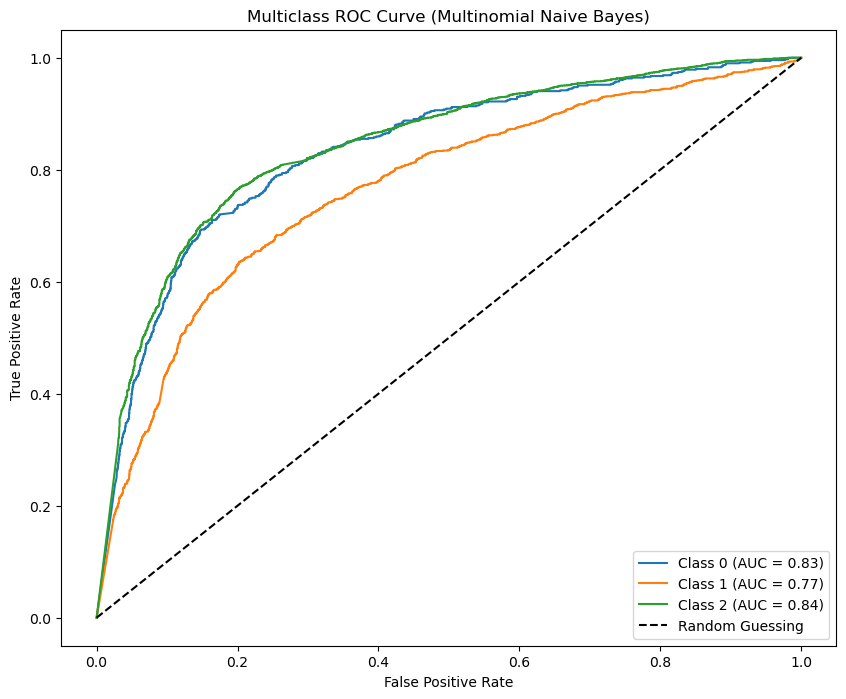

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train, X_test, and y_test are already defined
# Train the Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_proba = nb_model.predict_proba(X_test)

# Binarize the true labels for multiclass ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC and AUC for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Multinomial Naive Bayes)')
plt.legend(loc='lower right')
plt.show()



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

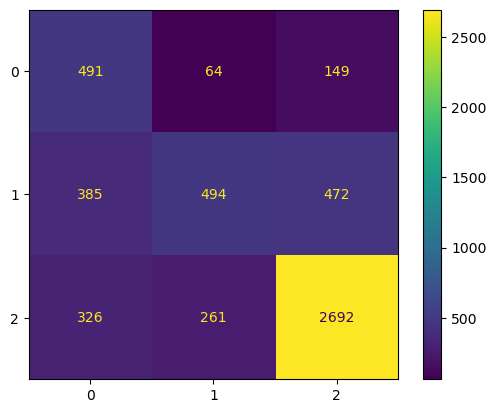

In [36]:
# Displaying the Confusion matrix of Multinomial Naive Bayes
cm_matrix = confusion_matrix(y_test,test_prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Multinomial Naive Bayes Classifier")
plt.show()

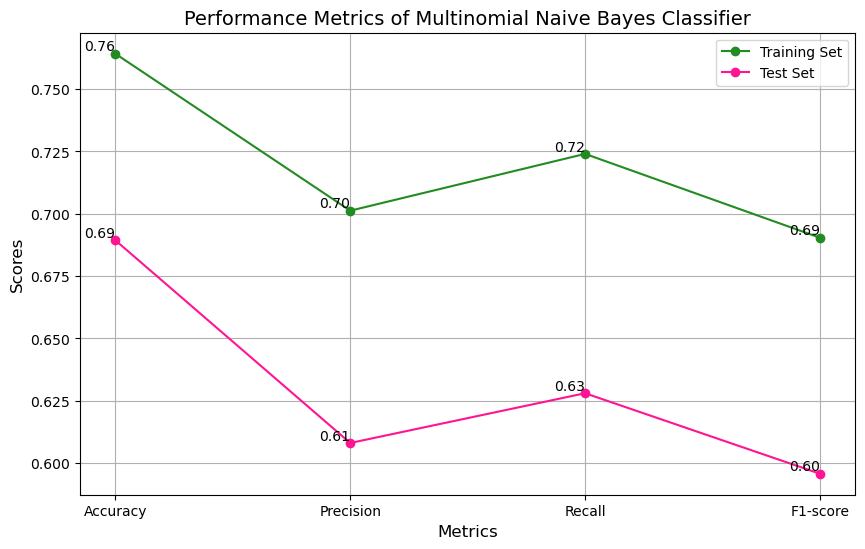

In [37]:
import matplotlib.pyplot as plt

# Extracting metrics for both training and testing sets
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_scores = [train_report['accuracy'], 
                train_report['macro avg']['precision'], 
                train_report['macro avg']['recall'], 
                train_report['macro avg']['f1-score']]
test_scores = [test_report['accuracy'], 
               test_report['macro avg']['precision'], 
               test_report['macro avg']['recall'], 
               test_report['macro avg']['f1-score']]

plt.figure(figsize=(10, 6))
plt.plot(metrics, train_scores, marker='o', linestyle='-', label='Training Set', color='forestgreen')
plt.plot(metrics, test_scores, marker='o', linestyle='-', label='Test Set', color='deeppink')

# Annotating points with score values
for metric, train_score, test_score in zip(metrics, train_scores, test_scores):
    plt.text(metric, train_score, f'{train_score:.2f}', ha='right', va='bottom', fontsize=10)
    plt.text(metric, test_score, f'{test_score:.2f}', ha='right', va='bottom', fontsize=10)

# Setting plot titles and labels
plt.title('Performance Metrics of Multinomial Naive Bayes Classifier', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.legend()
plt.grid(True)  # Optional: add grid for better visibility
plt.show()



In [38]:
# Generate predictions for the test set using the Multinomial Naive Bayes model
test_prediction = NB.predict(X_test)  # Assuming NB is your trained MultinomialNB model

# Storing the evaluation Result of Multinomial Naive Bayes
model_result = ['MultinomialNB', 
                accuracy_score(y_test, test_prediction), 
                precision_score(y_test, test_prediction, average='macro'), 
                recall_score(y_test, test_prediction, average='macro'), 
                f1_score(y_test, test_prediction, average='macro')]

# Append results to the DataFrame
result.loc[len(result)] = model_result



In [39]:
#choosing basic hyperparameters for the DTClassifier, with entropy criterion
DT = DecisionTreeClassifier(criterion='entropy', max_features='sqrt')
DT.fit(X_train,y_train)
prediction = DT.predict(X_train)           # Training Performance will be measured

In [40]:
print("\t\tThe Training Classification Report")
prediction = DT.predict(X_train)
print(classification_report(y_train,prediction))    #Print the Training Classification Report
print('\n')
print("\t\tThe Evaluation Classification Report")
prediction = DT.predict(X_test)
print(classification_report(y_test,prediction))  

		The Training Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1616
         1.0       0.98      1.00      0.99      3070
         2.0       1.00      0.99      1.00      7759

    accuracy                           0.99     12445
   macro avg       0.99      1.00      0.99     12445
weighted avg       0.99      0.99      0.99     12445



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.30      0.27      0.29       704
         1.0       0.48      0.47      0.48      1351
         2.0       0.76      0.78      0.77      3279

    accuracy                           0.64      5334
   macro avg       0.51      0.51      0.51      5334
weighted avg       0.63      0.64      0.63      5334



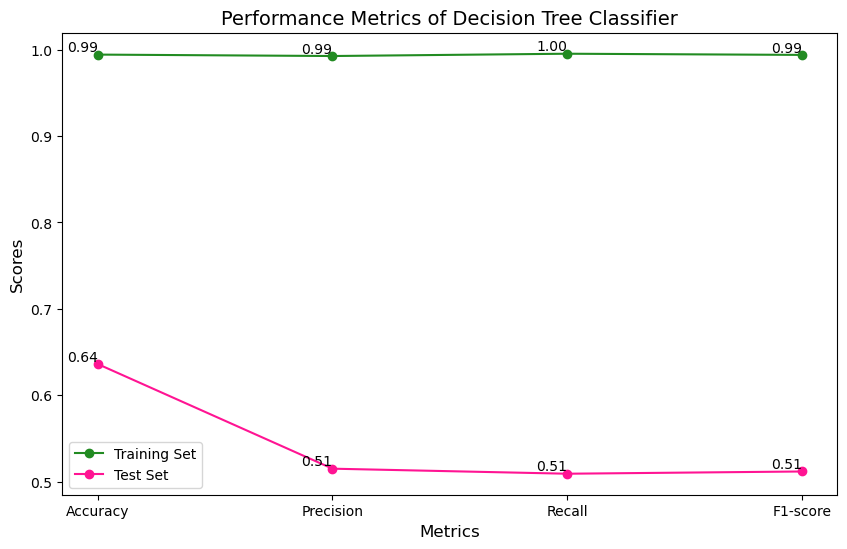

In [41]:
# Extracting metrics for both training and testing sets
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Using 'macro' as an example; you can switch to 'weighted' if needed
train_scores = [
    accuracy_score(y_train, DT.predict(X_train)),
    precision_score(y_train, DT.predict(X_train), average='macro'),
    recall_score(y_train, DT.predict(X_train), average='macro'),
    f1_score(y_train, DT.predict(X_train), average='macro')
]

test_scores = [
    accuracy_score(y_test, DT.predict(X_test)),
    precision_score(y_test, DT.predict(X_test), average='macro'),
    recall_score(y_test, DT.predict(X_test), average='macro'),
    f1_score(y_test, DT.predict(X_test), average='macro')
]

# Plotting the performance metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics, train_scores, marker='o', linestyle='-', label='Training Set', color='forestgreen')
plt.plot(metrics, test_scores, marker='o', linestyle='-', label='Test Set', color='deeppink')

# Annotate the points on the plot
for metric, train_score, test_score in zip(metrics, train_scores, test_scores):
    plt.text(metric, train_score, f'{train_score:.2f}', ha='right', va='bottom', fontsize=10)
    plt.text(metric, test_score, f'{test_score:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Performance Metrics of Decision Tree Classifier', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.legend()
plt.show()


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

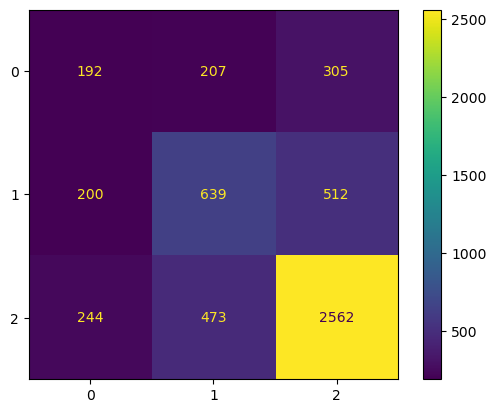

In [42]:
#Displaying the Confusion matrix of Decision Tree Classifier
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Decision Tree Classifier")
plt.show()

In [43]:
# Assuming `prediction` is the predicted labels for the test set
# If you haven't already, ensure to get predictions before this step
prediction = DT.predict(X_test)  # Make sure DT is your trained Decision Tree model

# Storing the evaluation Result of Decision Tree Classifier
model_result = [
    'DecisionTree',
    accuracy_score(y_test, prediction),
    precision_score(y_test, prediction, average='macro'),  # Change average to 'macro'
    recall_score(y_test, prediction, average='macro'),     # Change average to 'macro'
    f1_score(y_test, prediction, average='macro')          # Change average to 'macro'
]

# Append results to the DataFrame
result.loc[len(result)] = model_result


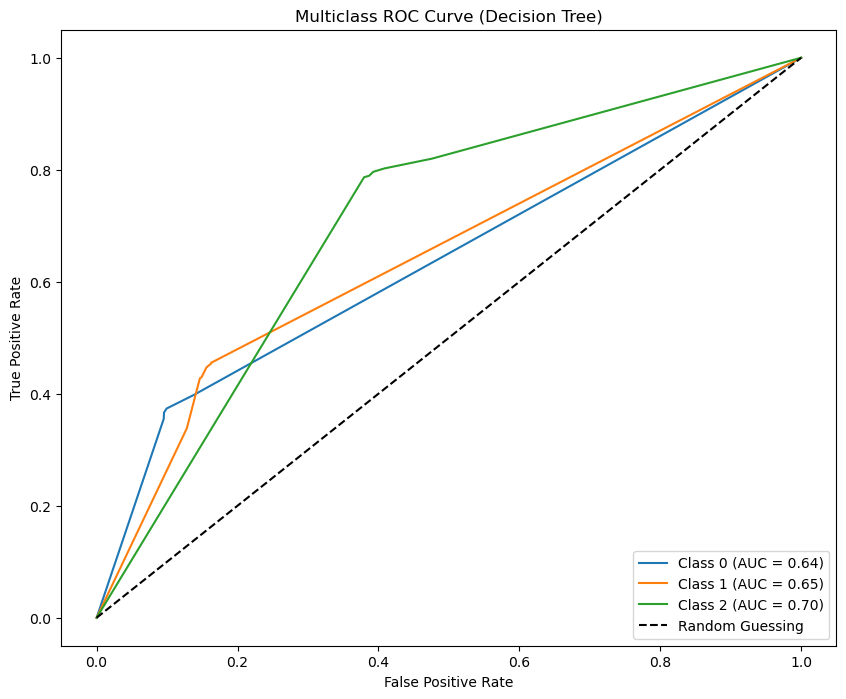

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train, X_test, and y_test are already defined
# Train the Decision Tree model
DT = DecisionTreeClassifier(random_state=42)
DT.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_proba = DT.predict_proba(X_test)

# Binarize the true labels for multiclass ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC and AUC for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Decision Tree)')
plt.legend(loc='lower right')
plt.show()


In [45]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data X_train and y_train defined
LSVC = LinearSVC()  # Define the LSVC model

LSVC.fit(X_train, y_train)  # Fit the model to the training data
prediction = LSVC.predict(X_train)  # Make predictions on the training data

# Use 'macro' or 'weighted' for multiclass evaluation
t_result.append((itr,
                 accuracy_score(y_train, prediction), 
                 precision_score(y_train, prediction, average='macro'),  # Change to 'macro' or 'weighted'
                 recall_score(y_train, prediction, average='macro'),     # Change to 'macro' or 'weighted'
                 f1_score(y_train, prediction, average='macro')))         # Change to 'macro' or 'weighted'
itr += 0.1


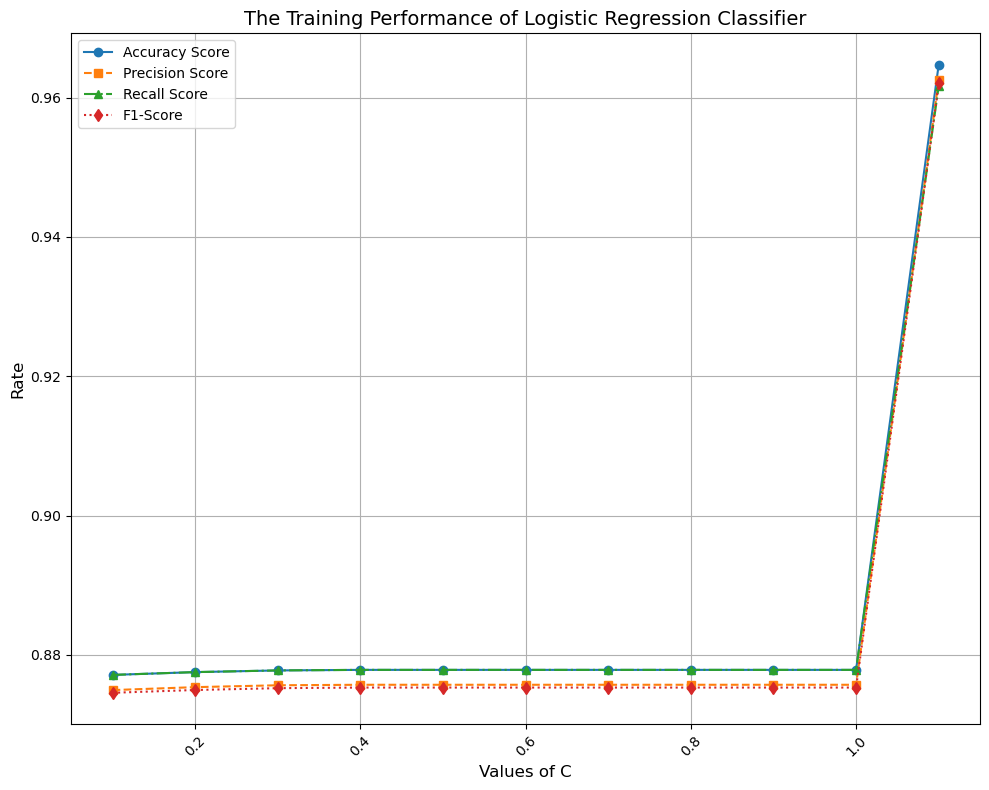

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming t_result is populated with the performance metrics
result_df = pd.DataFrame(t_result, columns=['C', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

# Plotting the training performance
plt.figure(figsize=(10, 8))
plt.plot(result_df['C'], result_df['Accuracy'], label='Accuracy Score', marker='o', linestyle='-')
plt.plot(result_df['C'], result_df['Precision'], label='Precision Score', marker='s', linestyle='--')
plt.plot(result_df['C'], result_df['Recall'], label='Recall Score', marker='^', linestyle='-.')
plt.plot(result_df['C'], result_df['F1-score'], label='F1-Score', marker='d', linestyle=':')

plt.xlabel("Values of C", fontsize=12)
plt.ylabel("Rate", fontsize=12)
plt.title("The Training Performance of Logistic Regression Classifier", fontsize=14)
plt.legend()
plt.grid()  # Add grid for better readability

# Optional: Rotate x-axis labels if there are many values
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()



In [47]:

# Training the Linear SVC for C = 0.9 for best performance
LSVC = LinearSVC(penalty='l2',dual=False, C=0.9)
LSVC.fit(X_train,y_train)

LinearSVC(C=0.9, dual=False)

In [48]:
prediction = LSVC.predict(X_test)
print(classification_report(y_test,prediction)) 

              precision    recall  f1-score   support

         0.0       0.44      0.48      0.46       704
         1.0       0.51      0.52      0.51      1351
         2.0       0.83      0.81      0.82      3279

    accuracy                           0.69      5334
   macro avg       0.59      0.60      0.60      5334
weighted avg       0.70      0.69      0.69      5334



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

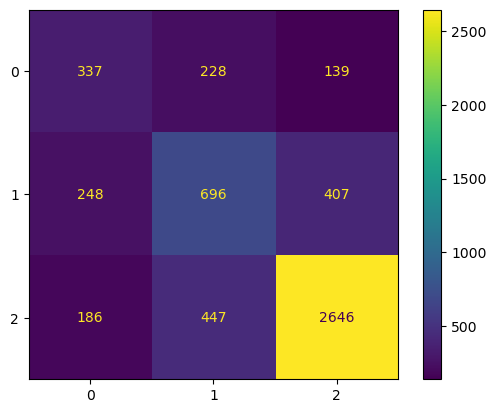

In [49]:
# Displaying the Confusion matrix of Linear SVC
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Linear Support-Vector Classifier")
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Saving the evaluation Result of Linear SVC
model_result = ['Linear SVC',
                accuracy_score(y_test, prediction),
                precision_score(y_test, prediction, average='weighted'),  # Use 'weighted' for multiclass
                recall_score(y_test, prediction, average='weighted'),     # Use 'weighted' for multiclass
                f1_score(y_test, prediction, average='weighted')]         # Use 'weighted' for multiclass

# Append to the results DataFrame
result.loc[len(result)] = model_result


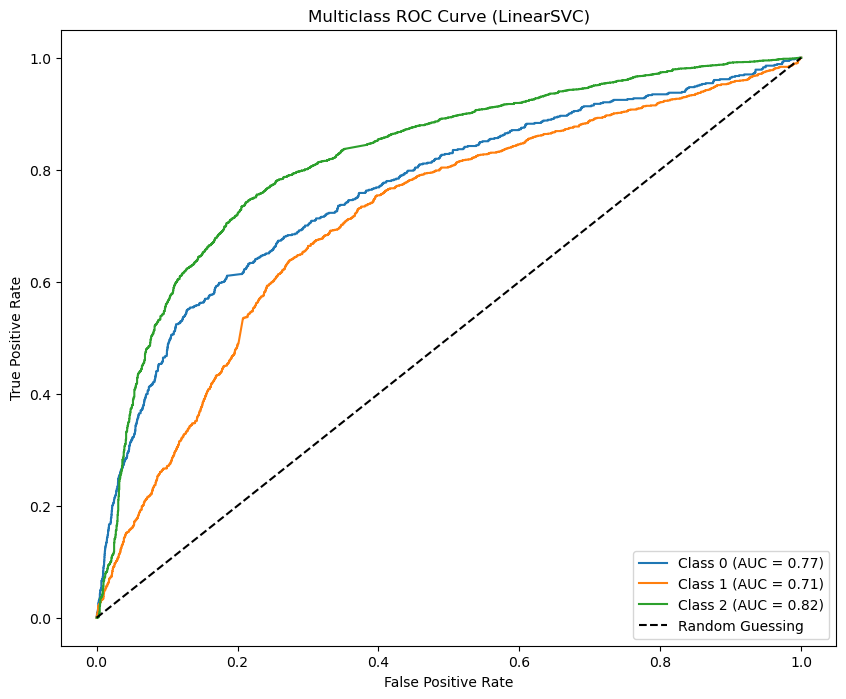

In [51]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train, X_test, and y_test are already defined
# Train the LinearSVC model and calibrate it to get probability estimates
LSVC = LinearSVC(random_state=42)
calibrated_LSVC = CalibratedClassifierCV(LSVC, method='sigmoid', cv='prefit')
LSVC.fit(X_train, y_train)
calibrated_LSVC.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_proba = calibrated_LSVC.predict_proba(X_test)

# Binarize the true labels for multiclass ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate ROC and AUC for each class
n_classes = y_test_binarized.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

# Plot random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (LinearSVC)')
plt.legend(loc='lower right')
plt.show()


In [52]:
#Printing the DataFrame containing the Testing Performance of each Model
result

Model Name  Accuracy  Precision Score  Recall Score  F1-Score
0  Random Forest Classifier  0.692163         0.667989      0.692163  0.672910
1       Logistic Regression  0.722535         0.711335      0.722535  0.715414
2             MultinomialNB  0.689351         0.608072      0.628027  0.595754
3              DecisionTree  0.636108         0.514852      0.509015  0.511606
4                Linear SVC  0.689726         0.695853      0.689726  0.692567

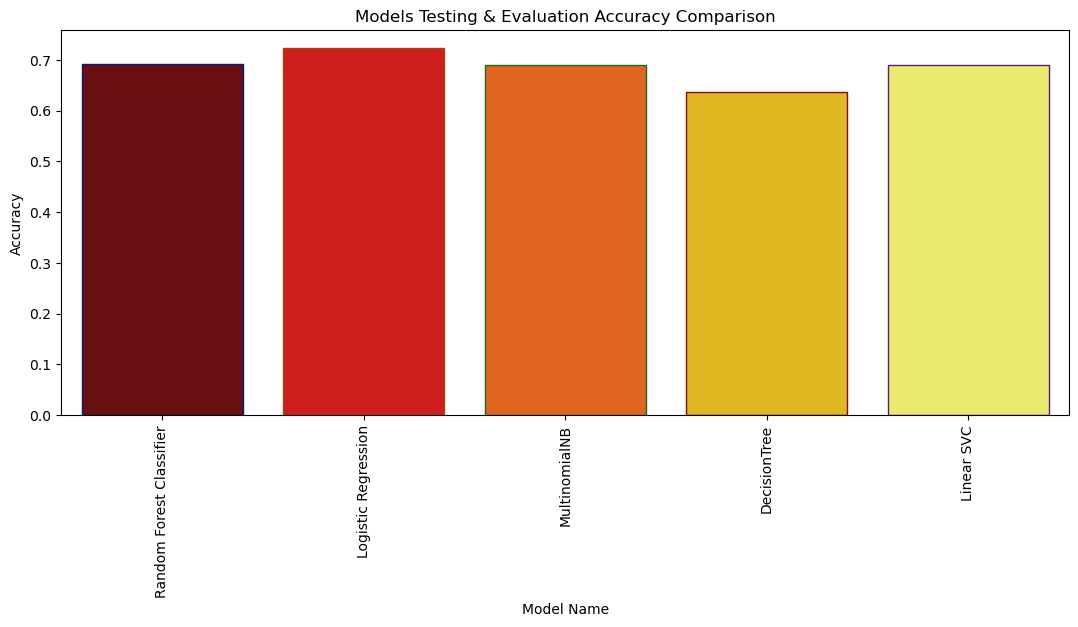

In [53]:
# Displaying a bar to compare between Models according to their Accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Accuracy",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Accuracy Comparison')
plt.show()

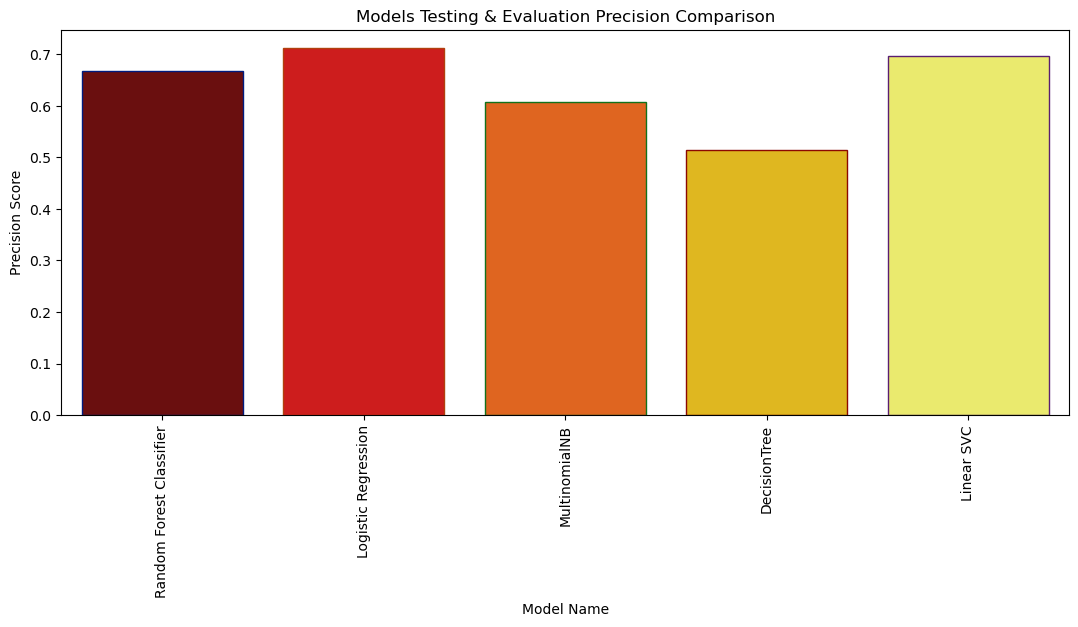

In [54]:
# Displaying a bar to compare between Models according to their Precision
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Precision Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Precision Comparison')
plt.show()

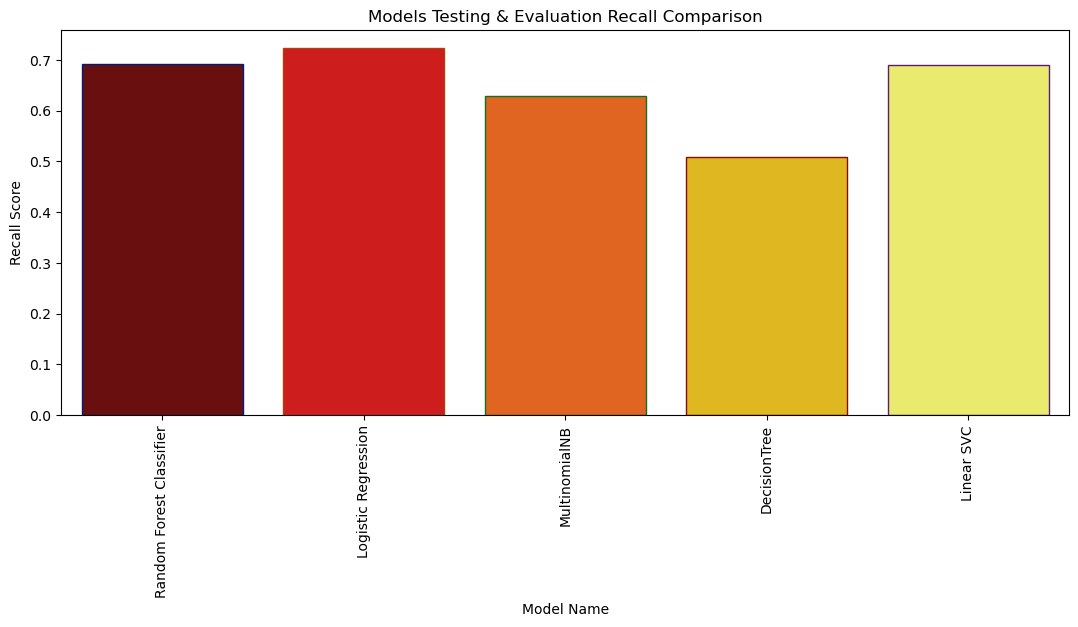

In [55]:
# Displaying a bar to compare between Models according to their Recall
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Recall Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Recall Comparison')
plt.show()

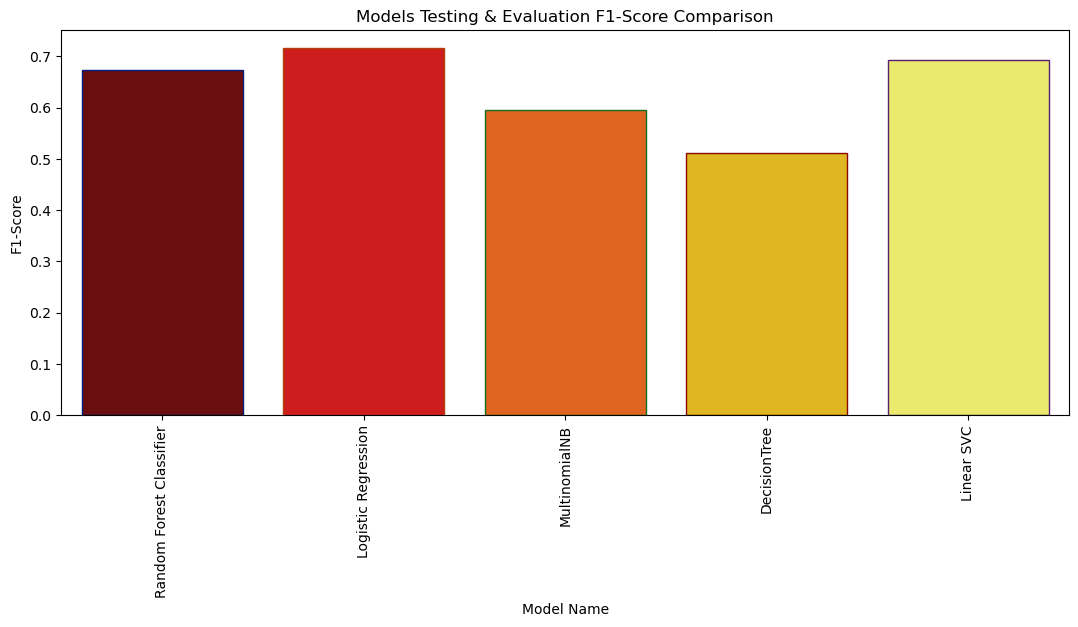

In [56]:
# Displaying a bar to compare between Models according to their F1-score
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="F1-Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation F1-Score Comparison')
plt.show()

In [57]:
# Putting All together in Pipeline
LGR_pipe = Pipeline([('vectorizer',vectorizer),('LGR',LGR)])

# Saving the Pipeline for Later using
pickle.dump(LGR_pipe, open('LGR_Model.sav', 'wb'))

In [58]:
from sklearn import set_config
set_config(display='diagram')

LGR_pipe

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, norm=None, strip_accents='ascii')),
                ('LGR',
                 LogisticRegression(C=0.9, max_iter=1000, random_state=41,
                                    solver='sag'))])

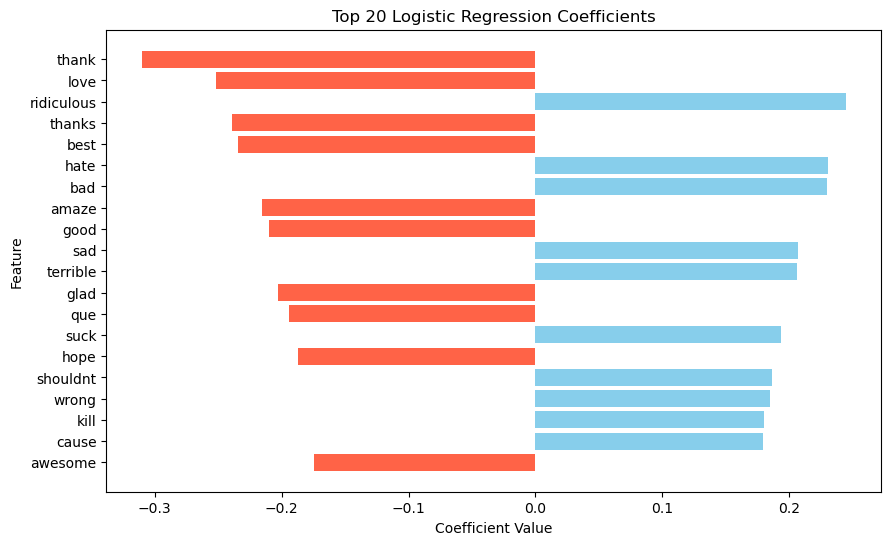

In [59]:
# Get the coefficients of the logistic regression model
coefficients = LGR.coef_[0]

# Sort the coefficients by their absolute values
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
top_n = 20  # Change this to display top N coefficients
top_coefficients = coefficients[sorted_indices][:top_n]
top_features = np.array(vectorizer.get_feature_names_out())[sorted_indices][:top_n]
threshold = 0.0  # Threshold value
colors = ['skyblue' if coef > threshold else 'tomato' for coef in top_coefficients]
# Plot the top N coefficients and their corresponding features
plt.figure(figsize=(10, 6))
plt.barh(np.arange(top_n), top_coefficients, color=colors)
plt.yticks(np.arange(top_n), top_features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top {} Logistic Regression Coefficients'.format(top_n))
plt.gca().invert_yaxis()  # Invert y-axis to display highest coefficients at the top
plt.show()

In [60]:
import pickle
from sklearn.pipeline import Pipeline

# Load the model
LGR_Model = pickle.load(open('LGR_Model.sav', 'rb'))

# The sentence to be tested
Sentence = "ugly."

# Preprocess the sentence
lower_sen = Sentence.lower()                                  # Lowercase
cleaned_sentence = remove_stopwords(lower_sen)                # Remove Stop Words
tken_sentence = word_tokenize(cleaned_sentence)               # Tokenize
lemmatized_sen = lemmatization(tken_sentence)                 # Lemmatization
processed_sen = ' '.join(lemmatized_sen)                      # Regroup

# Display the processed sentence
print("Processed Sentence:", processed_sen)

# Go through the pipeline (vectorizing & predicting)
sentiment = LGR_Model.predict([processed_sen])
sentiment_probabilities = LGR_Model.predict_proba([processed_sen])

# Get class names
class_labels = LGR_Model.classes_

# Display the predicted class
predicted_class = sentiment[0]

# Find the index of the predicted class
predicted_class_index = list(class_labels).index(predicted_class)

# Get the predicted probability
predicted_probability = sentiment_probabilities[0][predicted_class_index]

print(f"Predicted Class: {predicted_class}, Probability: {predicted_probability:.2f}")

# If you want to display all class probabilities
for i, label in enumerate(class_labels):
    print(f"Probability of {label}: {sentiment_probabilities[0][i]:.2f}")



Processed Sentence: ugly .
Predicted Class: 2.0, Probability: 0.43
Probability of 0.0: 0.25
Probability of 1.0: 0.31
Probability of 2.0: 0.43


In [61]:
##0-negative 1 - neutral 2- positive 

In [62]:
import pickle
import pandas as pd
from sklearn.pipeline import Pipeline

# Load the pre-trained model
LGR_Model = pickle.load(open('LGR_Model.sav', 'rb'))

# Load the unlabeled dataset
unlabeled_df = pd.read_csv('youtube_video_comments.csv')

# Define the preprocessing functions if not already defined
# These functions should handle lowercase, stop words removal, tokenization, and lemmatization
def preprocess_text(text):
    if isinstance(text, str):  # Check if the text is a string
        lower_sen = text.lower()                                  # Lowercase
        cleaned_sentence = remove_stopwords(lower_sen)            # Remove Stop Words
        tken_sentence = word_tokenize(cleaned_sentence)           # Tokenize
        lemmatized_sen = lemmatization(tken_sentence)             # Lemmatization
        processed_sen = ' '.join(lemmatized_sen)                  # Regroup
        return processed_sen
    return ""  # Return an empty string if the text is not valid

# Initialize lists to store results
predicted_labels = []
predicted_probabilities = []

# Iterate over each comment in the dataset
for comment in unlabeled_df['Comment']:
    processed_comment = preprocess_text(comment)
    
    # Only predict if there is valid text to process
    if processed_comment:
        sentiment = LGR_Model.predict([processed_comment])
        sentiment_probabilities = LGR_Model.predict_proba([processed_comment])

        # Store predicted class and probability
        predicted_class = sentiment[0]
        predicted_class_index = list(LGR_Model.classes_).index(predicted_class)
        predicted_probability = sentiment_probabilities[0][predicted_class_index]
    else:
        predicted_class = "Unknown"
        predicted_probability = None

    predicted_labels.append(predicted_class)
    predicted_probabilities.append(predicted_probability)

# Add the predictions to the original dataset
unlabeled_df['predicted_label'] = predicted_labels
unlabeled_df['predicted_probability'] = predicted_probabilities

# Save the labeled dataset
unlabeled_df.to_csv('labeled_youtube_comments.csv', index=False)

print("Labeled dataset saved as labeled_youtube_comments.csv")


Labeled dataset saved as labeled_youtube_comments.csv


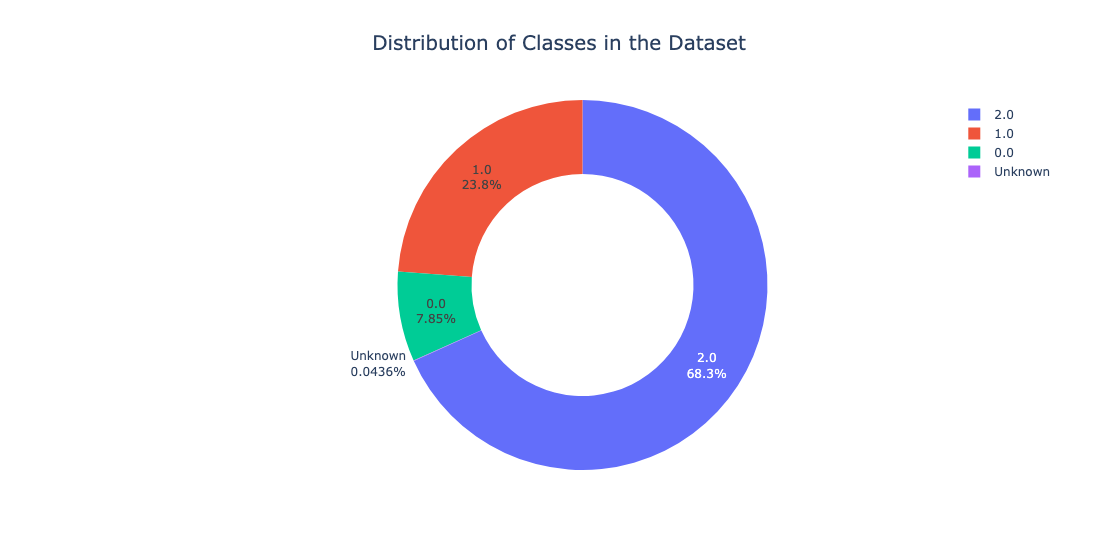

In [63]:
import pandas as pd
import plotly.graph_objects as go

# Load the labeled dataset
df = pd.read_csv('labeled_youtube_comments.csv')

# Get the label distribution using value_counts
labels = df['predicted_label'].value_counts().index
values = df['predicted_label'].value_counts().values

# Create the pie chart (donut chart by setting the hole)
fig = go.Figure(data=[go.Pie(labels=labels, 
                              values=values, 
                              hole=0.6,  # This creates the "donut" effect
                              textinfo='percent+label')])

# Update the layout for a clean look
fig.update_layout(title='Distribution of Classes in the Dataset',
                  title_font_size=20, title_x=0.5, width=750, height=550)

# Display the pie chart
fig.show()


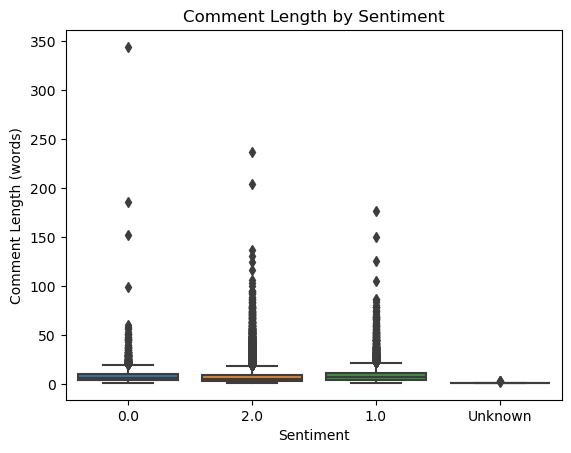

In [64]:
import seaborn as sns

df['comment_length'] = df['Comment'].apply(lambda x: len(str(x).split()))  # Count words in each comment
sns.boxplot(data=df, x='predicted_label', y='comment_length')
plt.title('Comment Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Comment Length (words)')
plt.show()



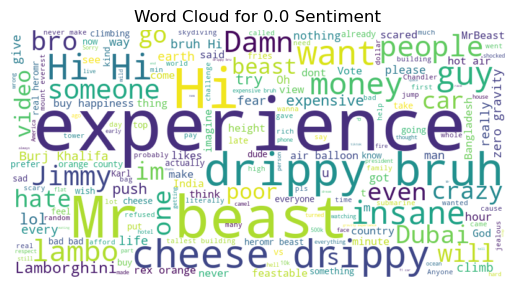

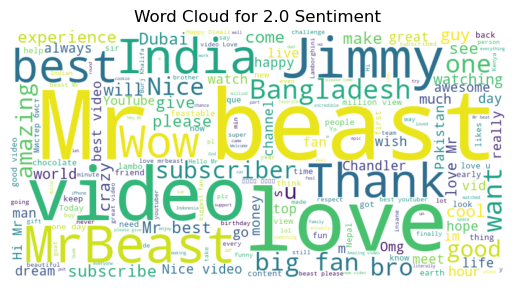

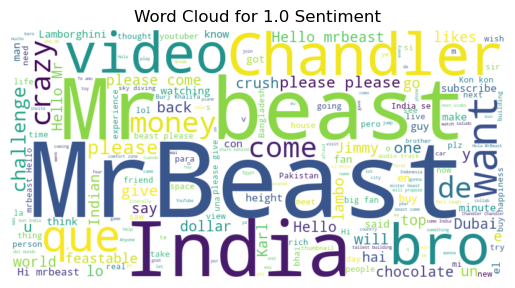

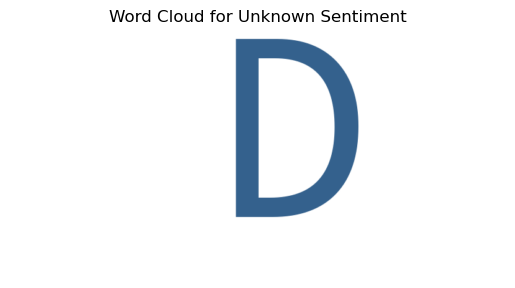

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in df['predicted_label'].unique():
    text = ' '.join(df[df['predicted_label'] == sentiment]['Comment'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()


In [66]:
##0-negative 1 - neutral 2- positive 

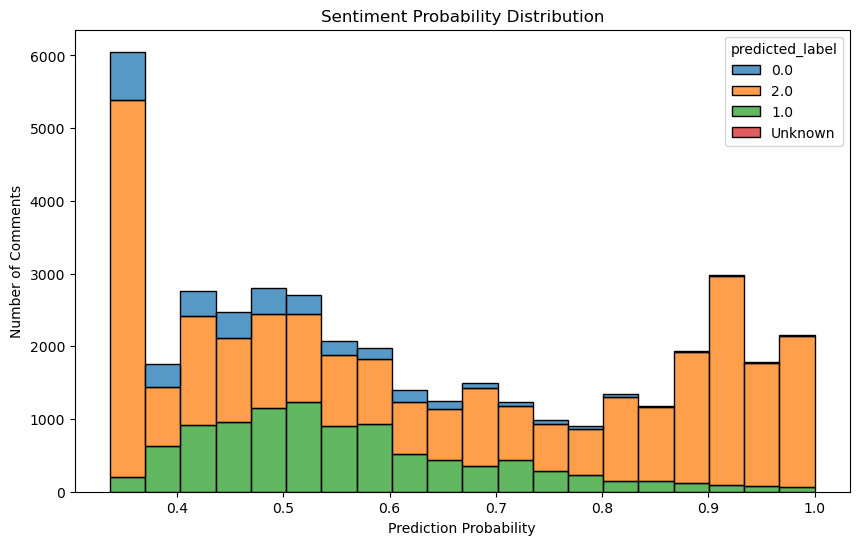

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='predicted_probability', hue='predicted_label', multiple="stack", bins=20)
plt.title('Sentiment Probability Distribution')
plt.xlabel('Prediction Probability')
plt.ylabel('Number of Comments')
plt.show()


NameError: name 'plt' is not defined